In [ ]:
import pyspark as spark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName('example')\
    .config('spark.some.config.option','some-value') \
    .getOrCreate()

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [3]:
business_raw_data = spark.read.json('business.json')

In [4]:
check_in_raw_data = spark.read.json('checkin.json')

In [5]:
tip_raw_data = spark.read.json('tip.json')

In [6]:
review_raw_data = spark.read.json('review.json')

In [7]:
user_raw_data = spark.read.json('user.json')

1.how many business each city has(show top 20)

In [8]:
city_count = business_raw_data.groupBy('city').count().orderBy('count', ascending=False)
city_count.show()

+---------------+-----+
|           city|count|
+---------------+-----+
|      Las Vegas|29370|
|        Toronto|18906|
|        Phoenix|18766|
|      Charlotte| 9509|
|     Scottsdale| 8837|
|        Calgary| 7736|
|     Pittsburgh| 7017|
|       Montréal| 6449|
|           Mesa| 6080|
|      Henderson| 4892|
|          Tempe| 4550|
|       Chandler| 4309|
|      Cleveland| 3605|
|       Glendale| 3543|
|        Madison| 3494|
|        Gilbert| 3462|
|    Mississauga| 3112|
|         Peoria| 1919|
|        Markham| 1766|
|North Las Vegas| 1548|
+---------------+-----+
only showing top 20 rows



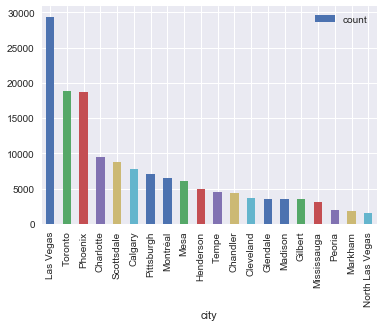

In [9]:
city_count_pd = city_count.toPandas()
city_count_pd[:20].plot.bar(x='city', y='count')

2. filter data

In [15]:
#select city in Canada in top 20 business_count and is open is true 
business_raw_data.createOrReplaceTempView("business_raw_data")
filtered_business_data = spark.sql("""SELECT*FROM business_raw_data
WHERE (business_raw_data.city = 'Toronto' or business_raw_data.city = 'Montréal' 
or business_raw_data.city = 'Calgary' 
or business_raw_data.city = 'Markham' or business_raw_data.city = 'Mississauga') AND is_open = 1
""")

In [16]:
#select review in 2018&2019 
review_raw_data.createOrReplaceTempView("review_raw_data")
filtered_review_data = spark.sql("""SELECT*FROM review_raw_data
WHERE date like '2018%' or date like '2019%'
""")

In [17]:
type(filtered_business_data)

pyspark.sql.dataframe.DataFrame

In [18]:
type(business_raw_data)

pyspark.sql.dataframe.DataFrame

In [19]:
filtered_review_data.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|ikCg8xy5JIg_NGPx-...|   0|2018-01-09 20:56:38|    0|yi0R0Ugj_xUx_Nek0...|  5.0|Went in for a lun...|     0|dacAIZ6fTM6mqwW5u...|
|b1b1eb3uo-w561D0Z...|   0|2018-01-30 23:07:38|    0|11a8sVPMUFtaC7_AB...|  1.0|Today was my seco...|     7|ssoyf2_x0EQMed6fg...|
|LUN6swQYa4xJKaM_U...|   0|2018-04-27 20:25:26|    0|qlXw1JQ0UodW7qrmV...|  4.0|Michael from Red ...|     0|bAhqAPoWaZYcyYi7b...|
|5OZlLXjU0FXUbrw8S...|   0|2018-02-01 19:01:16|    0|vBRxlgkpDTXjWiYBp...|  1.0|They keep there a...|     0|wNyiw6GfVfn5Kphqm...|
|wJj1EwYcXHdvA9zKq...|   0|2018-10-04 11:20:42|    0|NqYSX93Amv4sd5pPP...|  5.0|I called t

In [20]:
filtered_review_data.count()

1177662

In [21]:
review_raw_data.count()

6685900

In [22]:
#join review and business table
filtered_business_data.createOrReplaceTempView("filtered_business_data")
filtered_review_data.createOrReplaceTempView("filtered_review_data")
business_review_pair = spark.sql("""SELECT filtered_business_data.business_id,
filtered_business_data.name,filtered_business_data.categories,
filtered_business_data.stars as business_star,filtered_business_data.city,
filtered_review_data.review_id,filtered_review_data.date,filtered_review_data.user_id,
filtered_review_data.text,filtered_review_data.stars as review_star,filtered_review_data.cool,
filtered_review_data.funny,filtered_review_data.useful
FROM filtered_business_data, filtered_review_data
WHERE filtered_business_data.business_id = filtered_review_data.business_id""")

In [23]:
business_review_pair.show(5)

+--------------------+--------------------+--------------------+-------------+-----------+--------------------+-------------------+--------------------+--------------------+-----------+----+-----+------+
|         business_id|                name|          categories|business_star|       city|           review_id|               date|             user_id|                text|review_star|cool|funny|useful|
+--------------------+--------------------+--------------------+-------------+-----------+--------------------+-------------------+--------------------+--------------------+-----------+----+-----+------+
|-6c_bJblLXUwoWfmY...|Neo-Paws Internat...|Pet Services, Pet...|          2.5|    Toronto|SpJ5FkwIupUvg39oe...|2018-02-20 21:53:01|QzH6uDiJOVStePBuT...|My husband and I ...|        5.0|   0|    0|     1|
|-6c_bJblLXUwoWfmY...|Neo-Paws Internat...|Pet Services, Pet...|          2.5|    Toronto|f0bLb6n2qub7ubTdW...|2018-11-13 22:01:49|AFfh2ZLmu9LTNZ-3Q...|Thank god for Neo...|        5.0

In [24]:
business_review_pair.count()

128273

3. What are the popular restaurant styles in Canada in 2018&2019?

In [215]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
corpus = business_review_pair.select('categories')
corpus_df = corpus.toPandas()

In [221]:
categories = corpus_df['categories'].tolist()
categories = [str(i) for i in categories ]
X = vectorizer.fit_transform(categories) 
X = np.sum(X, axis=0)
X = np.array(X)[0]
cate_label = vectorizer.get_feature_names()

In [222]:
top_30_label = [cate_label[i] for i in np.argsort(X)[::-1][1:31]]
top_30_percentage = [X[i]/sum(X) for i in np.argsort(X)[::-1][1:31]]
print('%48s %25s' % ('Label name', 'Percentage of all labels'))
for i in range(30):
    print('%24s %24s %24f' % \
          (str(i+1), top_30_label[i], top_30_percentage[i]))

                                      Label name  Percentage of all labels
                       1                     food                 0.074561
                       2                     bars                 0.048958
                       3                nightlife                 0.025924
                       4                      tea                 0.018769
                       5                      new                 0.018355
                       6                 services                 0.016281
                       7                 japanese                 0.016053
                       8                breakfast                 0.015231
                       9                   brunch                 0.015173
                      10                   coffee                 0.014212
                      11                 canadian                 0.013724
                      12                 american                 0.013321
                      13 

In [226]:
#Mannully Pick out Labels which can represent food style:
d = {'Food Style': ['japanese','canadian','american','chinese','asian','italian'], 'Percentage': [0.016053,0.013724,0.013321,0.013158,0.008281,0.008192]}
df_food_style_rank = pd.DataFrame(data=d)
df_food_style_rank.index = np.arange(1, len(df_food_style_rank) + 1)
df_food_style_rank

,Food Style,Percentage
1,japanese,0.016053
2,canadian,0.013724
3,american,0.013321
4,chinese,0.013158
5,asian,0.008281
6,italian,0.008192


4.What are the top 50 restaurants with most reviews in selected cities in 2018&2019 ?

In [92]:
business_review_pair.createOrReplaceTempView("business_review_pair")
top_50 = spark.sql("""SELECT business_id,count(review_id) as review_count
FROM business_review_pair
GROUP BY business_id
ORDER BY count(review_id) desc
limit 50
""")

In [38]:
#check whether SQL query is correct
# top_50 = spark.sql("""SELECT name,count(review_id)
# FROM business_review_pair
# GROUP BY name
# ORDER BY count(review_id) desc
# """)
# top_50.groupBy().sum().collect()

[Row(sum(count(review_id))=128273)]

In [93]:
top_50.createOrReplaceTempView("top_50")
top_50_name = spark.sql("""SELECT top_50.business_id, business_raw_data.name,top_50.review_count
FROM top_50 left join business_raw_data on top_50.business_id = business_raw_data.business_id
""")

In [94]:
top_50_pd = top_50_name.toPandas()
top_50_pd

,business_id,name,review_count
0,r_BrIgzYcwo1NAuG9dLbpg,Pai Northern Thai Kitchen,600
1,htVvtLIFftBLqzRISjReDw,The Cheesecake Factory,357
2,yg_A_TpYkJjr1fef0J6QkQ,Konjiki Ramen,345
3,0W4lkclzZThpx3V65bVgig,Schwartz's,341
4,5T6kFKFycym_GkhgOiysIw,La Banquise,303
5,46Ld9Qc9nAx_A0jwclNZiw,Olive & Gourmando,257
6,_xAJZOKBMPOe47p1MphB2w,Fishman Lobster Clubhouse Restaurant,239
7,iGEvDk6hsizigmXhDKs2Vg,Seven Lives Tacos Y Mariscos,213
8,RtUvSWO_UZ8V3Wpj0n077w,KINKA IZAKAYA ORIGINAL,203
9,J6qWt6XIUmIGFHX5rQJA-w,L'Avenue,190


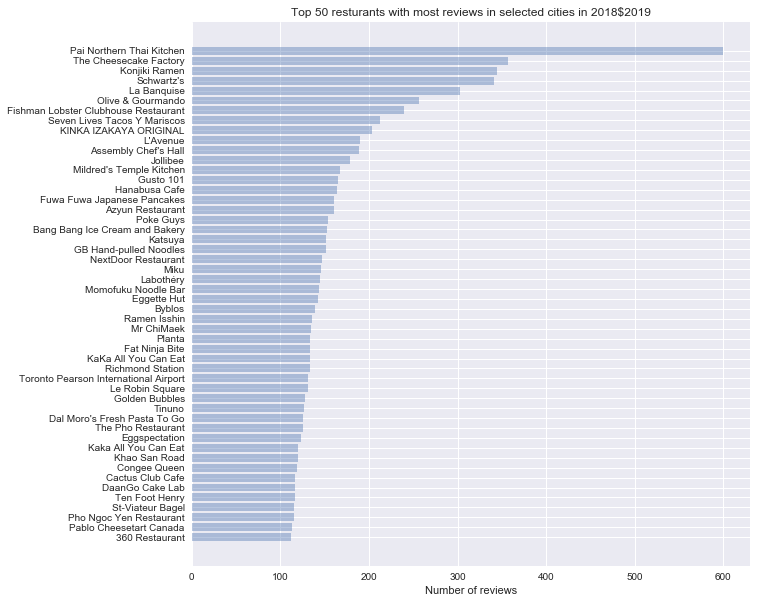

In [95]:
name_lst = top_50_pd['name'].tolist()
num_list = top_50_pd['review_count'].tolist()
plt.figure(figsize=(10,10))
y_pos = np.arange(len(name_lst))
plt.barh(y_pos,num_list, align='center', alpha = 0.4) 
plt.yticks(y_pos, name_lst)
plt.xlabel('Number of reviews')
plt.title('Top 50 resturants with most reviews in selected cities in 2018$2019')
plt.gca().invert_yaxis()

5.Whether the more reviews means the better quality?

In [103]:
top_50_name.createOrReplaceTempView("top_50_name")
business_star = spark.sql("""SELECT top_50_name.name,top_50_name.business_id,top_50_name.review_count,business_raw_data.stars as business_star
FROM top_50_name,business_raw_data 
WHERE top_50_name.business_id = business_raw_data.business_id
""")

In [104]:
business_star.show()

+--------------------+--------------------+------------+-------------+
|                name|         business_id|review_count|business_star|
+--------------------+--------------------+------------+-------------+
|Pai Northern Thai...|r_BrIgzYcwo1NAuG9...|         600|          4.5|
|The Cheesecake Fa...|htVvtLIFftBLqzRIS...|         357|          3.0|
|       Konjiki Ramen|yg_A_TpYkJjr1fef0...|         345|          4.0|
|          Schwartz's|0W4lkclzZThpx3V65...|         341|          4.0|
|         La Banquise|5T6kFKFycym_GkhgO...|         303|          4.0|
|   Olive & Gourmando|46Ld9Qc9nAx_A0jwc...|         257|          4.5|
|Fishman Lobster C...|_xAJZOKBMPOe47p1M...|         239|          4.0|
|Seven Lives Tacos...|iGEvDk6hsizigmXhD...|         213|          4.5|
|KINKA IZAKAYA ORI...|RtUvSWO_UZ8V3Wpj0...|         203|          4.0|
|            L'Avenue|J6qWt6XIUmIGFHX5r...|         190|          4.5|
|Assembly Chef's Hall|d4P7boUqiA2pR59jO...|         189|          4.0|
|     

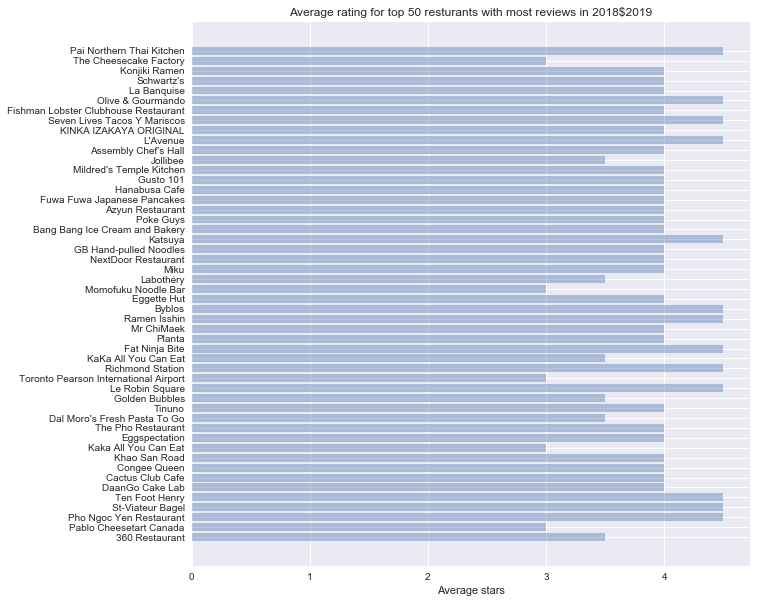

In [108]:
business_star_pd = business_star.toPandas()
name_lst = business_star_pd['name'].tolist()
star_list = business_star_pd['business_star'].tolist()
plt.figure(figsize=(10,10))
y_pos = np.arange(len(star_list))
plt.barh(y_pos,star_list, align='center', alpha = 0.4) 
plt.yticks(y_pos, name_lst)
plt.xlabel('Average stars')
plt.title('Average rating for top 50 resturants with most reviews in 2018$2019')
plt.gca().invert_yaxis()

In [174]:
star_lst = business_star_pd['business_star'].tolist()
a = [i for i in star_lst if i < 4.0]
b = [i for i in star_lst if i < 3.5]
print('The average rate for all resturants in selected cities is %f.' %(np.mean(business_star_pd['business_star'])))
print('The proportion of top 50 resturants with rate less than 4 is %f.' %(len(a)/50))
print('The proportion of top 50 resturants with rate less than 3.5 is %f.' %(len(b)/50))

The average rate for all resturants in selected cities is 3.970000.
The proportion of top 50 resturants with rate less than 4 is 0.220000.
The proportion of top 50 resturants with rate less than 3.5 is 0.100000.


In [187]:
# Check how strong the number of reviews and the average rating are related?
review_lst = business_star_pd['review_count'].tolist()
review_lst = [float(i) for i in review_lst]
star_lst = [float(i) for i in star_lst]
from scipy.stats.stats import pearsonr 
a = np.array(review_lst)
b = np.array(star_lst)
pearson_co = pearsonr(review_lst,star_lst)[0]
print('The correlation coefficient between number of reviews and average rating is %f.' \
      % (pearson_co))

The correlation coefficient between number of reviews and average rating is 0.103572.
